In [6]:

import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from labels_config import labels_info

np.complex = complex  # Patch temporaneo per NumPy > 1.24

SR = 44100
FRAME_LENGTH = 2048
HOP_LENGTH = 512
N_MFCC = 5


In [28]:

def extract_audio_features(audio_path, label_ranges):
    y, sr = librosa.load(audio_path, sr=SR)
    y_mono = librosa.to_mono(y) if y.ndim > 1 else y

    # Feature frame-by-frame
    rms = librosa.feature.rms(y=y_mono, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    zcr = librosa.feature.zero_crossing_rate(y=y_mono, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    centroid = librosa.feature.spectral_centroid(y=y_mono, sr=sr, hop_length=HOP_LENGTH)[0]
    mfccs = librosa.feature.mfcc(y=y_mono, sr=sr, n_mfcc=N_MFCC, hop_length=HOP_LENGTH)
    flatness = librosa.feature.spectral_flatness(y=y_mono, hop_length=HOP_LENGTH)[0]

    # Altre feature aggregate per frame
    chroma = librosa.feature.chroma_stft(y=y_mono, sr=sr, hop_length=HOP_LENGTH)
    chroma_mean = chroma.mean(axis=0)[:len(rms)]
    chroma_var = chroma.var(axis=0)[:len(rms)]

    spec_contrast = librosa.feature.spectral_contrast(y=y_mono, sr=sr, hop_length=HOP_LENGTH)
    spec_contrast_mean = spec_contrast.mean(axis=0)[:len(rms)]

    num_frames = len(rms)
    features = {
        'rms': rms,
        'zcr': zcr,
        'centroid': centroid,
        'spectral_flatness': flatness,
        'chroma_mean': chroma_mean,
        'chroma_var': chroma_var,
        'spec_contrast_mean': spec_contrast_mean
    }

    for i in range(mfccs.shape[0]):
        features[f'mfcc_{i+1}'] = mfccs[i, :num_frames]

    df = pd.DataFrame(features)
    df['time_sec'] = librosa.frames_to_time(np.arange(num_frames), sr=sr, hop_length=HOP_LENGTH)
    df['label'] = 'unlabeled'

    for label, (start, end) in label_ranges.items():
        df.loc[(df['time_sec'] >= start) & (df['time_sec'] < end), 'label'] = label

    return df


In [30]:

dataset_path = "../dataset"
participants = [p for p in os.listdir(dataset_path) if p.startswith("P")]
all_audio_features = []

for participant in participants:
    print(f"\n🔊 Processing audio for {participant}")
    participant_path = os.path.join(dataset_path, participant, "session")
    audio_file = os.path.join(participant_path, "P_audio.wav")

    if not os.path.exists(audio_file):
        print(f"❌ Audio file not found: {audio_file}")
        continue

    label_ranges = labels_info.get(participant)
    if not label_ranges:
        print(f"⚠️  No label ranges found for {participant}")
        continue

    df_audio = extract_audio_features(audio_file, label_ranges)
    df_audio['participant'] = participant
    all_audio_features.append(df_audio)

    out_csv = os.path.join(participant_path, f"{participant}_audio_features.csv")
    df_audio.to_csv(out_csv, index=False)
    print(f"✅ Saved to {out_csv} - Shape: {df_audio.shape}")
    display(df_audio.head())



🔊 Processing audio for P1
❌ Audio file not found: ../dataset\P1\session\P_audio.wav

🔊 Processing audio for P2
✅ Saved to ../dataset\P2\session\P2_audio_features.csv - Shape: (116441, 15)


,rms,zcr,centroid,spectral_flatness,chroma_mean,chroma_var,spec_contrast_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,time_sec,label,participant
0,0.000681,0.002441,1455.773565,0.000608,0.768604,0.019516,8.069840,-748.401306,116.121765,60.177513,29.193512,25.079830,0.00000,unlabeled,P2
1,0.000893,0.003906,898.156567,0.000109,0.577974,0.041375,12.993339,-758.131165,114.745438,74.760117,38.760323,21.998884,0.01161,unlabeled,P2
2,0.001356,0.005371,604.823357,0.000031,0.596990,0.037248,15.963675,-767.597046,106.741287,77.258270,46.931190,28.298431,0.02322,unlabeled,P2
3,0.001423,0.007324,463.202314,0.000013,0.672005,0.026249,15.236730,-762.404724,112.698868,79.875862,46.270882,26.408451,0.03483,unlabeled,P2
4,0.001544,0.007324,514.753121,0.000018,0.548616,0.064152,14.983025,-761.142944,114.569656,81.881134,48.255661,28.134277,0.04644,unlabeled,P2



🔊 Processing audio for P3
✅ Saved to ../dataset\P3\session\P3_audio_features.csv - Shape: (144085, 15)


,rms,zcr,centroid,spectral_flatness,chroma_mean,chroma_var,spec_contrast_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,time_sec,label,participant
0,0.000975,0.003418,922.268148,0.000141,0.568757,0.070313,9.403682,-797.854126,126.940353,65.700851,27.004795,23.037941,0.00000,unlabeled,P3
1,0.001367,0.004883,635.293548,0.000041,0.586231,0.053505,11.181095,-787.952576,139.323593,73.380981,29.452393,23.986908,0.01161,unlabeled,P3
2,0.001514,0.006348,485.000657,0.000016,0.588065,0.049228,16.573981,-785.808838,142.196014,76.196800,32.004063,24.690271,0.02322,unlabeled,P3
3,0.001569,0.005371,526.075562,0.000021,0.489184,0.072786,15.294729,-781.298523,146.376709,75.543457,27.656628,20.140215,0.03483,unlabeled,P3
4,0.001530,0.005371,580.995124,0.000028,0.436222,0.086219,17.074018,-787.180725,139.348007,72.020576,28.726921,24.960533,0.04644,unlabeled,P3



🔊 Processing audio for P4
✅ Saved to ../dataset\P4\session\P4_audio_features.csv - Shape: (156463, 15)


,rms,zcr,centroid,spectral_flatness,chroma_mean,chroma_var,spec_contrast_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,time_sec,label,participant
0,0.001093,0.003906,2133.541409,0.001338,0.923366,0.001696,8.440857,-671.216980,124.504715,27.416712,30.910133,24.757856,0.00000,unlabeled,P4
1,0.001175,0.004395,1337.766908,0.000337,0.852154,0.014620,12.245022,-697.971680,126.339417,44.895493,20.630247,20.142126,0.01161,unlabeled,P4
2,0.001317,0.005371,898.970873,0.000103,0.865859,0.005996,16.752679,-720.208313,119.312065,53.180893,10.296402,9.557909,0.02322,unlabeled,P4
3,0.000899,0.006348,769.287971,0.000071,0.823951,0.014093,13.766371,-719.543884,121.331665,56.801208,14.239481,13.306570,0.03483,unlabeled,P4
4,0.000956,0.003906,810.917124,0.000068,0.737884,0.026303,16.032415,-724.347046,117.863983,59.484421,18.966360,14.261374,0.04644,unlabeled,P4



🔊 Processing audio for P5
✅ Saved to ../dataset\P5\session\P5_audio_features.csv - Shape: (114814, 15)


,rms,zcr,centroid,spectral_flatness,chroma_mean,chroma_var,spec_contrast_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,time_sec,label,participant
0,0.000711,0.009766,2330.507742,0.001041,0.754768,0.021325,12.827170,-510.807953,15.795570,15.572551,15.205724,14.702290,0.00000,unlabeled,P5
1,0.000773,0.011230,1589.086160,0.000280,0.717946,0.020687,14.010117,-508.955902,18.400331,18.134369,17.697182,17.097717,0.01161,unlabeled,P5
2,0.000812,0.013672,1306.898631,0.000209,0.722012,0.030049,15.750894,-511.073120,15.426151,15.219509,14.879076,14.410720,0.02322,unlabeled,P5
3,0.000723,0.013184,1268.410172,0.000166,0.505338,0.070909,16.217825,-512.656799,13.185616,12.976454,12.631670,12.156923,0.03483,unlabeled,P5
4,0.000676,0.006348,1002.139209,0.000102,0.412118,0.094387,15.847019,-510.609192,16.055542,15.769846,15.300823,14.658965,0.04644,unlabeled,P5



🔊 Processing audio for P6
✅ Saved to ../dataset\P6\session\P6_audio_features.csv - Shape: (125760, 15)


,rms,zcr,centroid,spectral_flatness,chroma_mean,chroma_var,spec_contrast_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,time_sec,label,participant
0,0.000609,0.003906,2212.528907,0.002068,0.725491,0.030048,5.817237,-718.851318,112.400452,42.969780,21.739285,22.699799,0.00000,unlabeled,P6
1,0.000661,0.010742,1455.527664,0.000348,0.564434,0.059840,10.884061,-747.609375,99.032532,61.030109,33.061718,25.082981,0.01161,unlabeled,P6
2,0.000709,0.011719,1355.233538,0.000195,0.420170,0.088237,16.439259,-773.008911,76.148331,62.684139,46.378204,32.793056,0.02322,unlabeled,P6
3,0.000630,0.010254,1626.192257,0.000321,0.411827,0.096712,14.713786,-774.362549,74.361359,61.322784,45.747784,32.968185,0.03483,unlabeled,P6
4,0.000696,0.015137,1454.722884,0.000217,0.487233,0.113564,16.211452,-773.701782,74.974480,61.399105,45.860989,33.938484,0.04644,unlabeled,P6



🔊 Processing audio for P7
✅ Saved to ../dataset\P7\session\P7_audio_features.csv - Shape: (118433, 15)


,rms,zcr,centroid,spectral_flatness,chroma_mean,chroma_var,spec_contrast_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,time_sec,label,participant
0,0.0,0.0,0.0,1.000001,0.0,0.0,10.072341,-926.261414,0.0,0.0,0.0,0.0,0.00000,unlabeled,P7
1,0.0,0.0,0.0,1.000001,0.0,0.0,10.072341,-926.261414,0.0,0.0,0.0,0.0,0.01161,unlabeled,P7
2,0.0,0.0,0.0,1.000001,0.0,0.0,10.072341,-926.261414,0.0,0.0,0.0,0.0,0.02322,unlabeled,P7
3,0.0,0.0,0.0,1.000001,0.0,0.0,10.072341,-926.261414,0.0,0.0,0.0,0.0,0.03483,unlabeled,P7
4,0.0,0.0,0.0,1.000001,0.0,0.0,10.072341,-926.261414,0.0,0.0,0.0,0.0,0.04644,unlabeled,P7



🔊 Processing audio for P8
✅ Saved to ../dataset\P8\session\P8_audio_features.csv - Shape: (147511, 15)


,rms,zcr,centroid,spectral_flatness,chroma_mean,chroma_var,spec_contrast_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,time_sec,label,participant
0,0.000000,0.000000,0.000000,1.000001,0.000000,0.000000,4.748740,-632.637756,0.0,0.0,0.0,0.0,0.00000,unlabeled,P8
1,0.000000,0.000000,0.000000,1.000001,0.000000,0.000000,4.748740,-632.637756,0.0,0.0,0.0,0.0,0.01161,unlabeled,P8
2,0.000000,0.000000,0.000000,1.000001,0.000000,0.000000,4.748740,-632.637756,0.0,0.0,0.0,0.0,0.02322,unlabeled,P8
3,0.000012,0.077148,4039.194390,0.177007,0.840148,0.015664,7.472535,-632.637756,0.0,0.0,0.0,0.0,0.03483,unlabeled,P8
4,0.000045,0.102539,4293.816064,0.016018,0.868690,0.013366,14.587873,-632.637756,0.0,0.0,0.0,0.0,0.04644,unlabeled,P8


In [31]:
if all_audio_features:
    df_all = pd.concat(all_audio_features, ignore_index=True)
    df_all.to_csv("all_participants_audio_features.csv", index=False)
    print(f"✅ Dataset completo salvato: all_participants_audio_features.csv - Shape: {df_all.shape}")
    display(df_all.head())

✅ Dataset completo salvato: all_participants_audio_features.csv - Shape: (923507, 15)


,rms,zcr,centroid,spectral_flatness,chroma_mean,chroma_var,spec_contrast_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,time_sec,label,participant
0,0.000681,0.002441,1455.773565,0.000608,0.768604,0.019516,8.069840,-748.401306,116.121765,60.177513,29.193512,25.079830,0.00000,unlabeled,P2
1,0.000893,0.003906,898.156567,0.000109,0.577974,0.041375,12.993339,-758.131165,114.745438,74.760117,38.760323,21.998884,0.01161,unlabeled,P2
2,0.001356,0.005371,604.823357,0.000031,0.596990,0.037248,15.963675,-767.597046,106.741287,77.258270,46.931190,28.298431,0.02322,unlabeled,P2
3,0.001423,0.007324,463.202314,0.000013,0.672005,0.026249,15.236730,-762.404724,112.698868,79.875862,46.270882,26.408451,0.03483,unlabeled,P2
4,0.001544,0.007324,514.753121,0.000018,0.548616,0.064152,14.983025,-761.142944,114.569656,81.881134,48.255661,28.134277,0.04644,unlabeled,P2


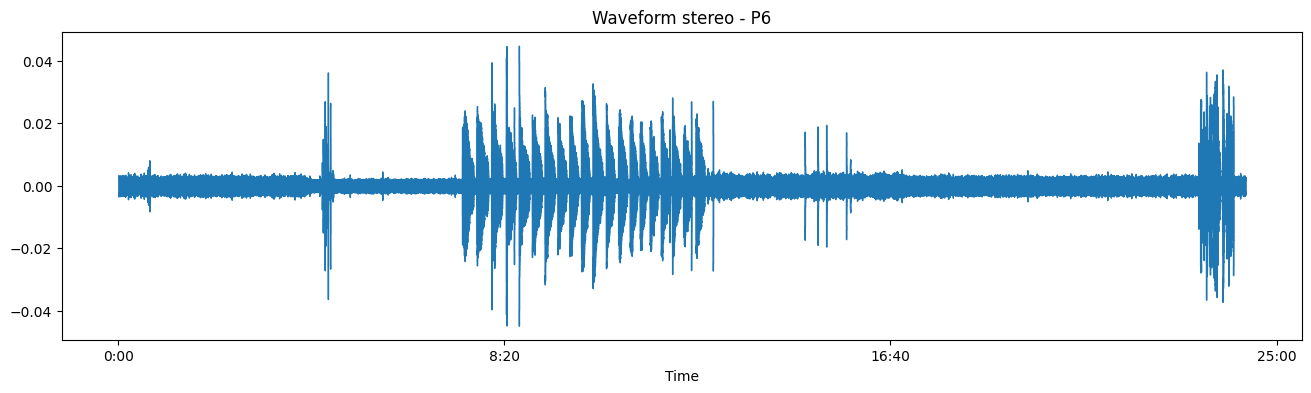

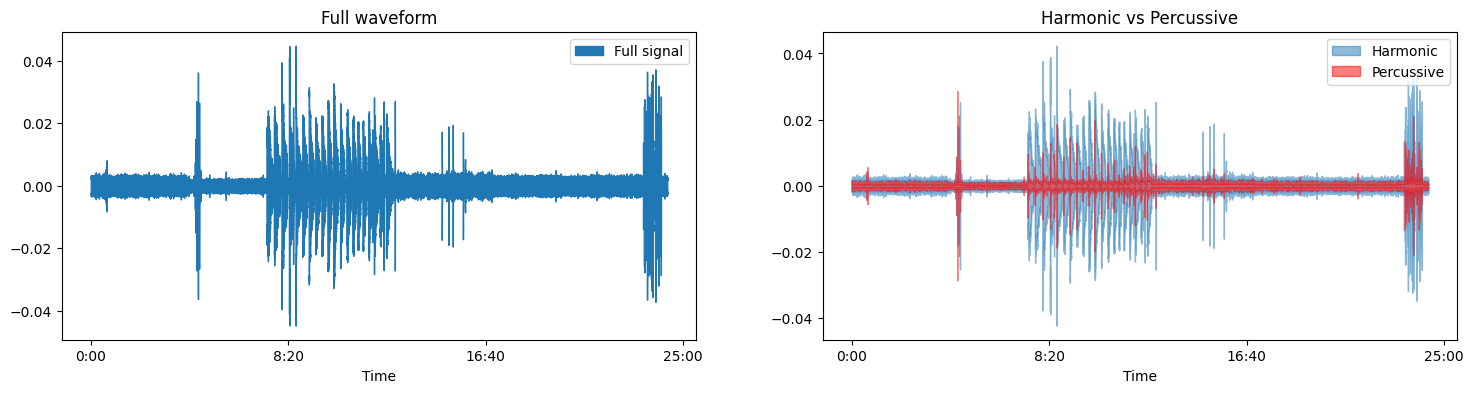

In [19]:

import librosa.display
import matplotlib.pyplot as plt

# === Visualizzazione Waveform stereo ===
audio_path = os.path.join(dataset_path, participants[5], "session", "P_audio.wav")
y, sr = librosa.load(audio_path, sr=None, mono=False)

fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
librosa.display.waveshow(y, sr=sr, ax=ax)
ax.set(title='Waveform stereo - ' + participants[5])
ax.label_outer()
plt.show()

# === Separazione armonica e percussiva ===
y_mono, sr = librosa.load(audio_path, sr=None)
y_harm, y_perc = librosa.effects.hpss(y_mono)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(18, 4))
librosa.display.waveshow(y_mono, sr=sr, ax=ax1, label='Full signal')
ax1.set(title='Full waveform')
librosa.display.waveshow(y_harm, sr=sr, ax=ax2, alpha=0.5, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, label='Percussive')
ax2.set(title='Harmonic vs Percussive')
ax1.legend()
ax2.legend()
plt.show()


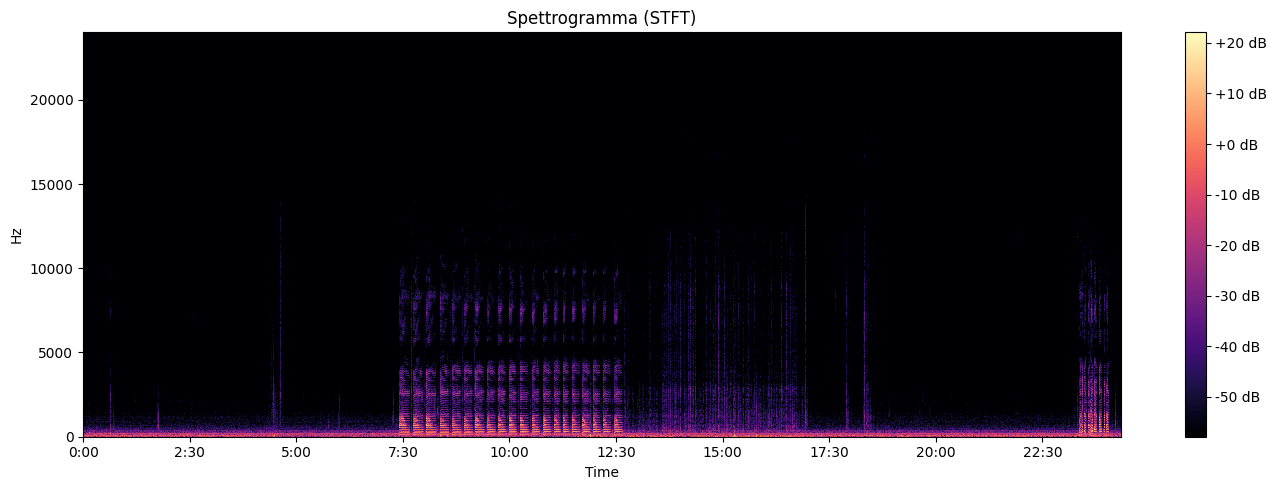

In [20]:
# === Spettrogramma (STFT) ===
S = librosa.stft(y_mono)
S_db = librosa.amplitude_to_db(abs(S))

plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format="%+2.f dB")
plt.title("Spettrogramma (STFT)")
plt.tight_layout()
plt.show()


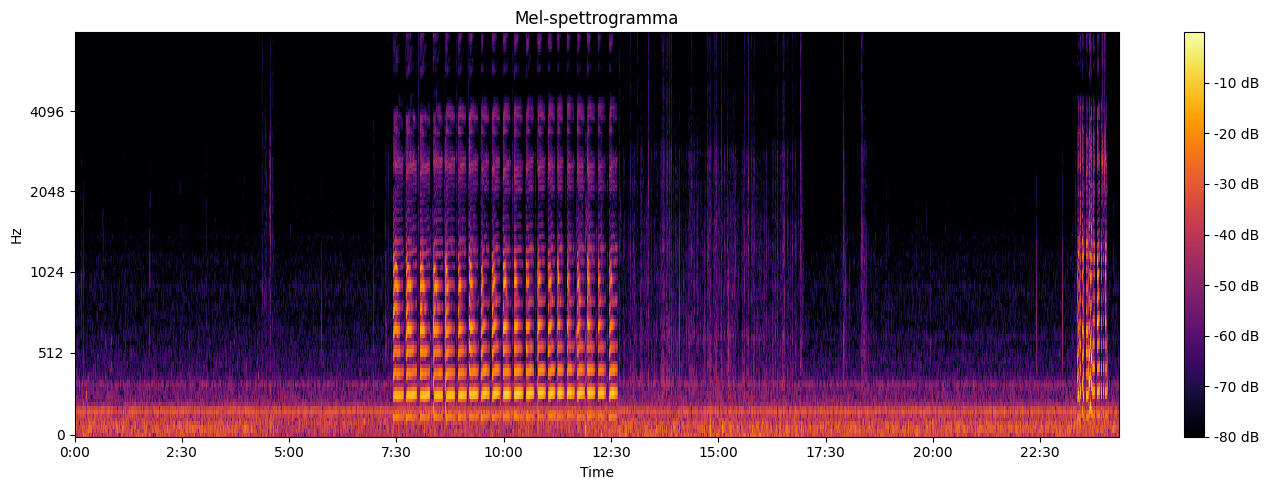

In [21]:

# === Mel-spectrogram ===
mel_spect = librosa.feature.melspectrogram(y=y_mono, sr=sr, n_mels=128, fmax=8000)
mel_db = librosa.power_to_db(mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000, cmap='inferno')
plt.colorbar(format="%+2.f dB")
plt.title("Mel-spettrogramma")
plt.tight_layout()
plt.show()


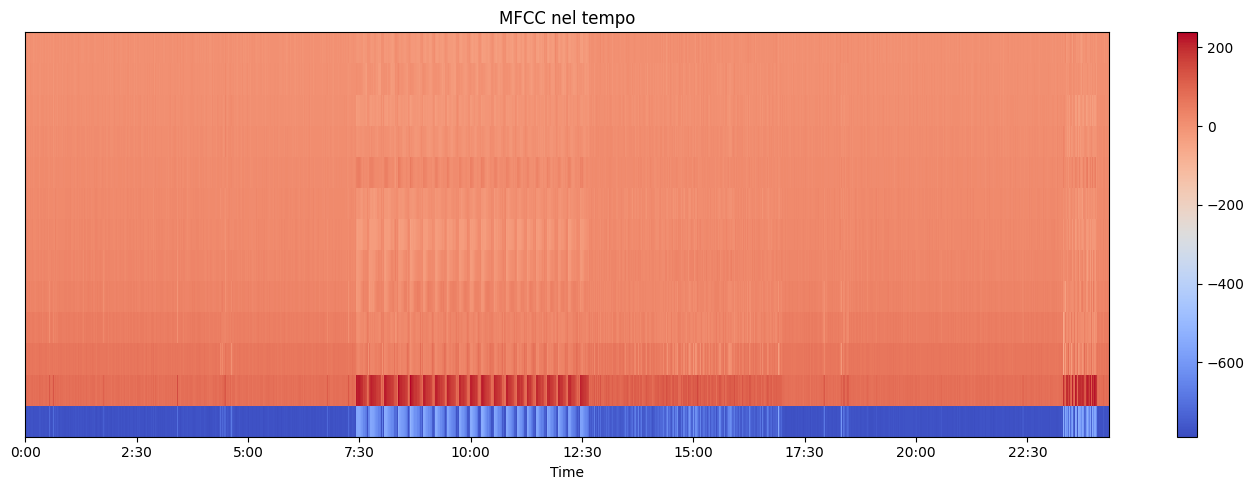

In [22]:

# === MFCC ===
mfcc = librosa.feature.mfcc(y=y_mono, sr=sr, n_mfcc=13)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='coolwarm')
plt.colorbar()
plt.title("MFCC nel tempo")
plt.tight_layout()
plt.show()

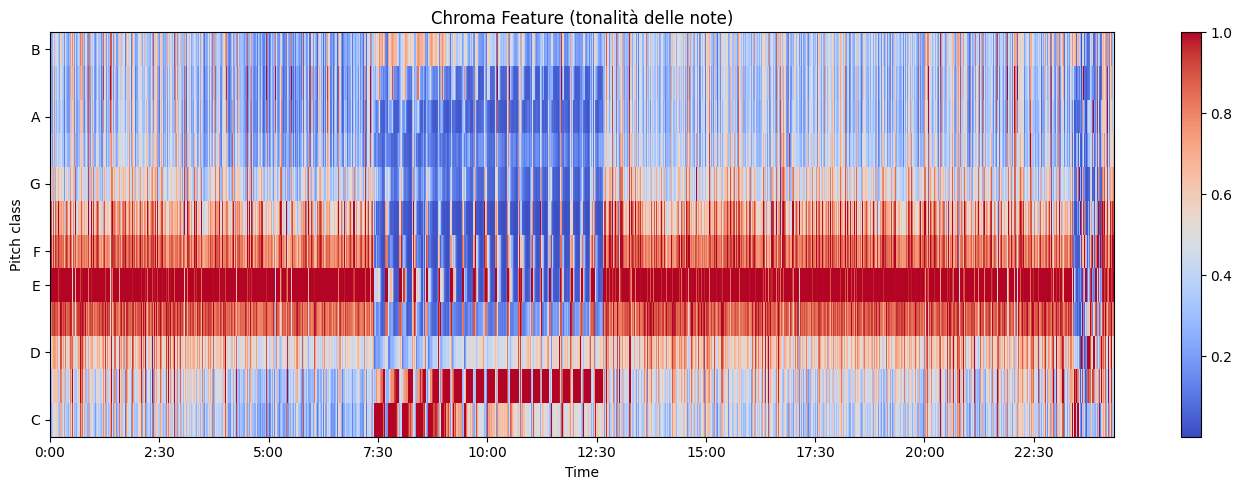

In [23]:

# === Chroma Feature ===
chroma = librosa.feature.chroma_stft(y=y_mono, sr=sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm', sr=sr)
plt.colorbar()
plt.title("Chroma Feature (tonalità delle note)")
plt.tight_layout()
plt.show()
